# Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [1]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [2]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [3]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [4]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [16]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


# Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [19]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test=pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test

# Analyse descriptive [Attention ne prend pas encore en compte la séparation ci dessus]

Regardons la structure de la table:

In [20]:
df_train.head()

,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall
229659,B001G7BWQ2,"[0, 1]","Full disclosure, I am a brand new guitar playe...","12 30, 2012",A1MRGI2CTPU4Z3,P. C. Burger,Beautiful instrument,1356825600,5
339214,B0040ICQVO,"[0, 0]",USING THESE FOR WEDDING CENTERPIECES AND LOOK ...,"04 19, 2014",A2GZRJQ86XIV12,Krystal,LOOK GREAT,1397865600,4
96206,B00063678K,"[0, 0]","Does exactly what it says, offers a pedal for ...","03 4, 2014",A3U6KVSQMET9SY,Miles Roozen,Excellent,1393891200,5
470571,B00CA4S3HQ,"[1, 1]",Great music. I was recommended to get this on ...,"12 3, 2013",A2ZFBTGPDP6PH6,C Fox,Love it,1386028800,5
317550,B003JCF5Y2,"[0, 0]","Great cable at a great price. Quiet, well made...","09 7, 2011",A3ACQ419NKCXVK,bluecrew84,A must have for your studio arsenal,1315353600,5


Etudions les dimensions clés de la table:

In [9]:
Nbreviews=len(df_train)
Nbproducts=len(set(df_train["asin"]))
Nbreviewers=len(set(df_train["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 400146
Le nombre total de produits est: 74955
Le nombre total de reviewers est: 283288
Soit un nombre moyen de 5.3 reviews par produit
Soit un nombre moyen de 1.4 reviews par reviewers


Analysons la distribution des notes des reviews

count    400146.00
mean          4.24
std           1.20
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: overall, dtype: float64


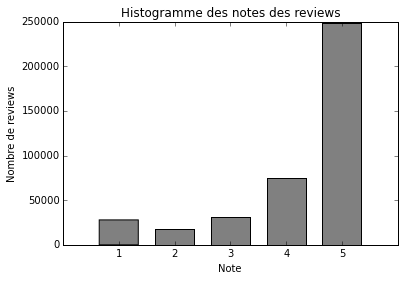

In [55]:
print(df_train["overall"].describe().round(2))
%matplotlib inline 
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Nombre de reviews");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

count    74986.00
mean         4.23
std          1.00
min          1.00
25%          4.00
50%          4.57
75%          5.00
max          5.00
Name: overall, dtype: float64


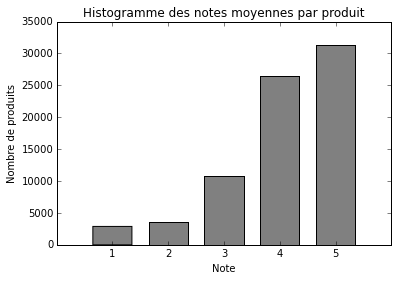

In [60]:
average_note_byproduct=df_train[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Nombre de produits");

Regardons la distribution du nombre de reviews par utilisateur.

count    283393.00
mean          1.41
std           2.03
min           1.00
25%           1.00
50%           1.00
75%           1.00
max         386.00
dtype: float64


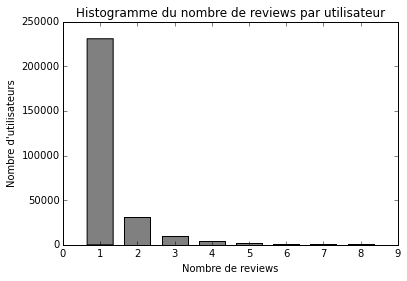

In [62]:
import collections
Nbreview_by_user=collections.Counter(df_train["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("Nombre d'utilisateurs");

Définissons la fonction de comptage du nombre de mots d'une review et appliquons la à nos données

In [26]:
import re
def countWords(review):
    return (len(re.findall(r'\w+', review["reviewText"])))

In [28]:
df_train["countWordsReview"] = df_train.apply(countWords, axis = 1)
df_test["countWordsReview"] = df_train.apply(countWords, axis = 1)

Regardons la distribution du nombre de mots des reviews

In [67]:
print(df_train["countWordsReview"].describe().round(2))

count    400146.00
mean         90.97
std         124.02
min           0.00
25%          28.00
50%          51.00
75%         103.00
max        6045.00
Name: countWordsReview, dtype: float64


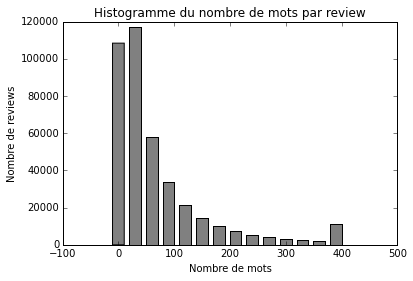

In [68]:
%matplotlib inline 
bins=range(0,430,30)
a = np.clip(df_train["countWordsReview"], 0, 400)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

Maintenant regardons plus spécifiquement entre 0 et 100 mots

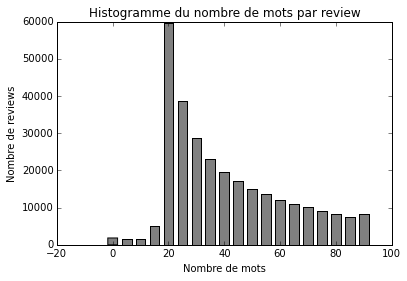

In [69]:
a = [s for s in df_train["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

In [15]:
#buf = StringIO()
#for i in range(df.shape[0]):
    #buf.write(df["reviewText"][i])

En dernière étape, nous allons créer des variables pour le mois et le jour de la review, ce qui peut influencer la note.

In [168]:
from datetime import datetime
df_train["Month"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_test["Month"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_train["Month"].head()

229659    12
339214    04
96206     03
470571    12
317550    09
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [169]:
df_train["Weekday"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_test["Weekday"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_train["Weekday"].head()

229659    Sun
339214    Sat
96206     Tue
470571    Tue
317550    Wed
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

# Préparation des données

On prépare les données en utilisant les fonctions `Count Vectorizer` et `TfidfTransformer` du package `sklearn`. Notons que nous utilisons les stopwords donnés par `nltk` pour réduire le nombre de mots.

In [202]:
from sklearn.feature_extraction.text import CountVectorizer
corpus=list(df_train["reviewText"])
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(corpus)
X_train_counts.shape

(400146, 218690)

In [203]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
count_vect = CountVectorizer(stop_words= stopwords.words('english'))
X_train_counts = count_vect.fit_transform(corpus)
X_train_counts.shape

(400146, 218567)

In [204]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(400146, 218567)

In [189]:
##from scipy.sparse import hstack
##X_train_tfidf_ReviewAndSummary=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary])
##print(X_train_tfidf_ReviewAndSummary.shape)

(400146, 260435)


# Machine Learning

In [206]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train.astype('category'))

In [207]:
corpus_test=list(df_test["reviewText"])
X_test_counts = count_vect.transform(corpus_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
predicted = clf.predict(X_test_tfidf)

In [208]:
from sklearn.linear_model import SGDClassifier
SGDclass=SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2=SGDclass.fit(X_train_tfidf, y_train.astype('category'))
predicted2 = clf2.predict(X_test_tfidf)

# Evaluation de la performance

In [209]:
np.mean(predicted == y_test)

0.6199406219698711

In [210]:
np.mean(predicted2 == y_test)

0.61961074402471084

In [211]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))

             precision    recall  f1-score   support

        1.0       0.95      0.01      0.02      7048
        2.0       0.00      0.00      0.00      4480
        3.0       0.25      0.00      0.00      7654
        4.0       0.50      0.00      0.00     18899
        5.0       0.62      1.00      0.77     61956

avg / total       0.56      0.62      0.48    100037

[[   59     0     0     0  6989]
 [    1     0     0     0  4479]
 [    2     0     1     4  7647]
 [    0     0     0     7 18892]
 [    0     0     3     3 61950]]


D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [212]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted2))
print(metrics.confusion_matrix(y_test, predicted2))

             precision    recall  f1-score   support

        1.0       0.85      0.00      0.01      7048
        2.0       0.00      0.00      0.00      4480
        3.0       0.00      0.00      0.00      7654
        4.0       0.00      0.00      0.00     18899
        5.0       0.62      1.00      0.77     61956

avg / total       0.44      0.62      0.47    100037

[[   28     0     0     0  7020]
 [    4     0     0     0  4476]
 [    0     0     0     0  7654]
 [    1     0     0     0 18898]
 [    0     0     0     0 61956]]


D:\Users\acombess\PythonENSAE\python\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Then: draw multi class ROC Curve using this example: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [213]:
for i in range(0,20) :
        print(str(corpus_test[i]) + "------ We predict "+ str(predicted[i]))

This is a well made clutch that is very easy to use and holds up well.  I have both the Remo and this one and they are about equal in performance.  The Gibraltar is more robust and a hair larger and easier to operate the quick release.  It's also a bit heavier.  The Gibraltar is about eight bucks cheaper too.  I use the Remo on my DW 6000 series light weight hihat stand with the very short rod cause it's smaller and lighter.  I use the Gibraltar on my heavier stands.  They are both excellent and are the only way to go for the future.  I'll never go back to screw ons again.------ We predict 5.0
They always seem to produce albums that I can listen to from beginning to end. I need to see these guys live next.------ We predict 5.0
soft, light weight, long.  leather ends hold strap pins tightly.  I ordered another!------ We predict 5.0
For price, this unit fits our bill perfectly.We use it in for a Line Dance Group which meets 2 days a week.  We connect it to he Auditorium soundsystem and w

# Analyse de la performance en fonction du nombre de mots

In [255]:
def createBins(x):
    if x["countWordsSummary"] < 30:
        return(30)
    elif x["countWordsSummary"] < 100:
        return(100)
    elif x["countWordsSummary"] < 200:
        return(200)
    else:
        return(300)

In [256]:
dfy = pd.DataFrame(y_test)
dfy["predicted"] = predicted
dfy["reviewText"] = df_test["reviewText"]
dfy["countWordsReview"] = dfy.apply(countWords, axis = 1)
dfy["summary"] = df_test["summary"]
dfy["countWordsSummary"] = dfy.apply(countWords, axis = 1)
dfy["qualite"] = abs(predicted - y_test)
dfy["bin"] = dfy.apply(createBins, axis = 1)
dfy.head()

,overall,predicted,reviewText,countWordsReview,summary,countWordsSummary,qualite,bin
126863,5,5,I'm using this clamp to mount a ride cymbal on...,39,"Solid, great addition",39,0,100
393670,4,1,Pros - I bought a 12&#34; x 24&#34; Remo Mondo...,223,"A+ Superb Quality, 5 stars accept slightly sho...",223,3,300
376320,5,5,First off I want to note that these speakers a...,72,This really helps dialing in your mix,72,0,100
139913,5,5,.The ArRe-Se label appears to be Swiss or Fren...,166,Double-Gs...,166,0,200
383749,4,5,We bought this for our granddaughter and she l...,29,Karaoke Player,29,1,30


In [262]:
np.mean(dfy[dfy.bin==30]["qualite"])

0.7352659142878218

In [235]:
sum(abs(predicted - y_test))

58595.0

# Bits of useless code (so far)

In [36]:
#an example with another function TfidfVectorizer using frequency instead of count
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

{'this': 1.0, 'is': 1.0, 'strange': 1.4054651081081644, 'very': 1.0, 'nice': 1.4054651081081644}


In [127]:
#Meh... Does not work yet
#nltk.download()
#all_words = nltk.FreqDist(w.lower() for w in nltk.word_tokenize(list(df["summary"]))) Does not work yet